# SAD2 2022/2023 - Introduction to Variational Inference

This week we will introduce the variational inference. The concepts discussed in previous week, namely MLE, ELBO, and KL divergence come together in this framework. Variational inference embraces a family of methods for approximating complicated densities by a simpler class of densities, as introduced [here](https://www.cs.toronto.edu/~bonner/courses/2020s/csc2547/week2/variational-inference-tutorial,-mohamed,-2015.pdf).

This week we will start working with Pyro. Pyro is a dynamic object-oriented programming language created to support what we call the probabilistic programming. Pyro combines the elegance and expressiveness of Python with the performance and robustness of C++. Pyro is built on top of the PyTorch library and uses the same underlying C++ code.

This lab is heavily based on [Pyro tutorial on Stochastic Variational Inference](https://pyro.ai/examples/svi_part_i.html). It is possible to implement this exercise solely based on this tutorial, however, we want to let you know that there are more useful resources regarding Pyro (cue Project 1 ;)):

   - [Introduction to Pyro](http://pyro.ai/examples/intro_long.html)
   - [GMM in Pyro](https://pyro.ai/examples/gmm.html)
   - [SVI Part II: Conditional Independence, Subsampling, and Amortization](https://pyro.ai/examples/svi_part_ii.html)

In [137]:
import random
from collections import defaultdict

import torch
import pyro
device = torch.device("cpu")
import numpy as np
import pandas as pd
import pyro.distributions.constraints as constraints
# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
import arviz
arviz.style.use("arviz-darkgrid")

## 0. The "Variational" in "Variational Inference"

The "Variational" in "Variational Inference" is a reference to the fact that in variational inference we optimize a function, called the variational lower bound, over a set of variables known as variational parameters. The variational parameters are usually chosen to be the natural parameters of a probability distribution, which means that they can be used to define a probability distribution. The goal of variational inference is to find a set of variational parameters that makes the variational lower bound as tight as possible.

There are many different ways to formulate the variational lower bound, but the most common one is based on the Kullback-Leibler (KL) divergence. The KL divergence is a measure of the difference between two probability distributions. In the context of variational inference, we can think of the KL divergence as a measure of the difference between the true posterior distribution and the approximate posterior distribution. The goal of variational inference is to find a set of variational parameters that minimizes the KL divergence between the true posterior and the approximate posterior.

Recall the KL divergence is defined as:

$KL(p||q) = \sum_x p(x) \log \frac{p(x)}{q(x)}$

where $p$ and $q$ are two probability distributions. In the context of variational inference, $p$ is the true posterior distribution and $q$ is the approximate posterior distribution.

The variational lower bound is then defined as:

$\mathcal{L}(p, q) = \sum_x p(x) \log q(x) - KL(p||q)$

The goal of variational inference is to find a set of variational parameters that minimizes the KL divergence between the true posterior and the approximate posterior. In other words, we want to find a set of variational parameters that makes the variational lower bound as tight as possible.

There are many different ways to optimize the variational lower bound. The most common one is gradient descent. In gradient descent, we take the gradient of the variational lower bound with respect to the variational parameters and then update the variational parameters in the direction that maximizes the variational lower bound.

There are many different ways to initialize the variational parameters. The most common one is to initialize them randomly. Once the variational parameters have been optimized, we can then use them to define a probability distribution. This probability distribution is our approximate posterior distribution. We can then use this approximate posterior distribution to make predictions about the data.

There are many different ways to evaluate the quality of the approximate posterior distribution as well. The most common one is to compute the KL divergence between the true posterior and the approximate posterior. Other common evaluation metrics include the log-likelihood and the predictive accuracy.

## 1. ELBO and KL divergence in Variational Inference [TODO]
Same question, differently formulated: Explain VI using only (mostly) ELBO and KL divergence


## 2. Infer the posterior distribution of $\mu$ and $\sigma$ ($\tau$) in the example form the lecture.

## Problem statement

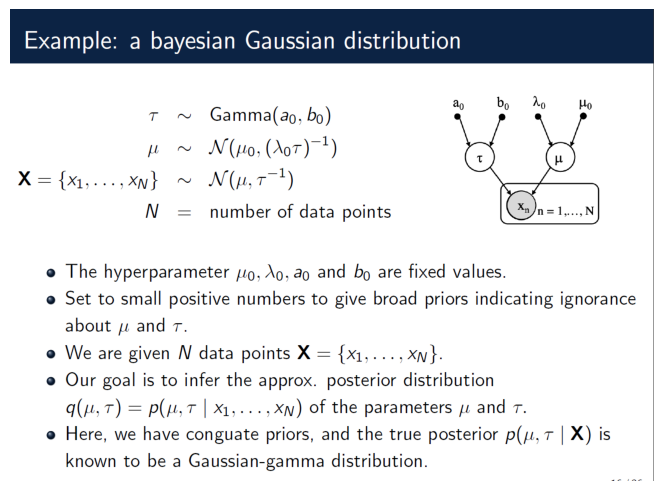

In [138]:
fig, ax = plt.subplots(1, 1)
ax.imshow(plt.imread('img.png'))

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Draw data

In [139]:
from torch.distributions import Normal

MEAN = 5.0
STD = 0.5
N_SAMPLES = 100

#smoll data
data = torch.tensor([10., 10., 10., 10., 10.])

# #big data
NORMAL = Normal(torch.tensor([MEAN]), torch.tensor([STD]))
data = NORMAL.sample((N_SAMPLES,))

### Define model
See [Models in Pyro](http://pyro.ai/examples/intro_long.html#:~:text=%C2%B6-,Probabilistic,-models%20in%20Pyro)

In [140]:
import pyro.distributions as dist
a=torch.tensor(2.)
b=torch.tensor(2.)
lam_0=torch.tensor(3.)
mu_0=torch.tensor(1.)
def model(data,a,b,lam_t,m_t):
    a_0=pyro.param("a",a)
    b_0=pyro.param("b",b)
    lam_0=pyro.param("lam",lam_t)
    mu_0=pyro.param("mu",m_t)
    tau=pyro.sample("tau",dist.Gamma(a_0,b_0))
    mu=pyro.sample("mean",dist.Normal(mu_0,1/(lam_0*tau)))
    with pyro.plate("data",len(data)):
        return pyro.sample("observation",dist.Normal(mu,1/tau),obs=data)


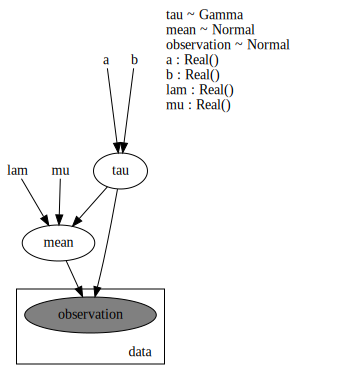

In [141]:
# sudo apt-get install graphviz
# pip install graphviz

pyro.render_model(model, model_args=(data,a,b,lam_0,mu_0), render_distributions=True,render_params=True)

### Define guide $q_{\phi}({\bf z})$

See [Guides in Pyro](http://pyro.ai/examples/intro_long.html#:~:text=original%20KL%2Ddivergence.-,Background%3A%20%E2%80%9Cguide%E2%80%9D%20programs%20as%20flexible%20approximate%20posteriors,%C2%B6,-In%20variational%20inference)


In [142]:
def guide(data,a,b,lau,mu):
    mean_es=torch.mean(data)
    std_es=torch.std(data)
    scale_1=pyro.param("mean_scale",torch.randn([])*mean_es/10,constraint=constraints.positive)
    scale_2=pyro.param("tau_scale",torch.randn([])*3,constraint=constraints.positive)
    mean_1=pyro.param("mean_mean",torch.randn([])*1+mean_es)
    mean_2=pyro.param("tau_mean",torch.randn([])*3*mean_es)

    mean=pyro.sample("mean",dist.Normal(mean_1,scale_1))
    std=pyro.sample("tau",dist.Gamma(mean_2,scale_2))
    return {"mean": mean, "tau": std}

In [143]:
torch.rand([])

tensor(0.3487)

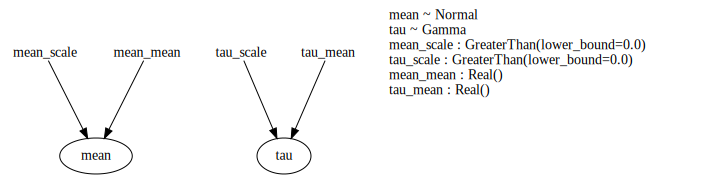

In [144]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)
pyro.render_model(guide, model_args=(data,a,b,lam_0,mu_0), render_distributions=True,render_params=True)

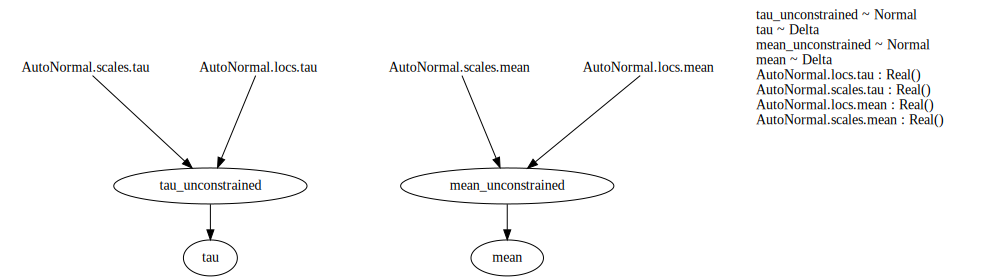

In [145]:
pyro.render_model(auto_guide,model_args=(data,a,b,lam_0,mu_0),render_params=True,render_distributions=True)

### Define optimizer

Optional: do some tweaks to the optimizer and see if it changes the params and convergence.

In [146]:
from pyro.optim import Adam

adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

### Define [$SVI$ class](https://docs.pyro.ai/en/stable/inference_algos.html?highlight=svi)

In [166]:
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

### Do the inference; report the inferred mean and std

In [167]:
n_steps = 500
losses=[]
# do gradient steps
for step in range(n_steps):
    loss=svi.step(data[:,0],a,b,lam_0,mu_0)
    losses.append(loss)
    if step%25==0:
        print("step: {} loss: {}".format(step,loss))

step: 0 loss: 68.6696605682373
step: 25 loss: 88.36199903488159
step: 50 loss: 59.181830406188965
step: 75 loss: 79.37654733657837
step: 100 loss: 63.83018147945404
step: 125 loss: 59.947176933288574
step: 150 loss: 66.86922407150269
step: 175 loss: 64.10874283313751
step: 200 loss: 67.1344723701477
step: 225 loss: 89.80670917034149
step: 250 loss: 64.78829193115234
step: 275 loss: 63.703773498535156
step: 300 loss: 63.45492601394653
step: 325 loss: 73.64208459854126
step: 350 loss: 67.13002038002014
step: 375 loss: 60.26913022994995
step: 400 loss: 62.74455392360687
step: 425 loss: 63.829450368881226
step: 450 loss: 59.85195231437683
step: 475 loss: 88.60582554340363


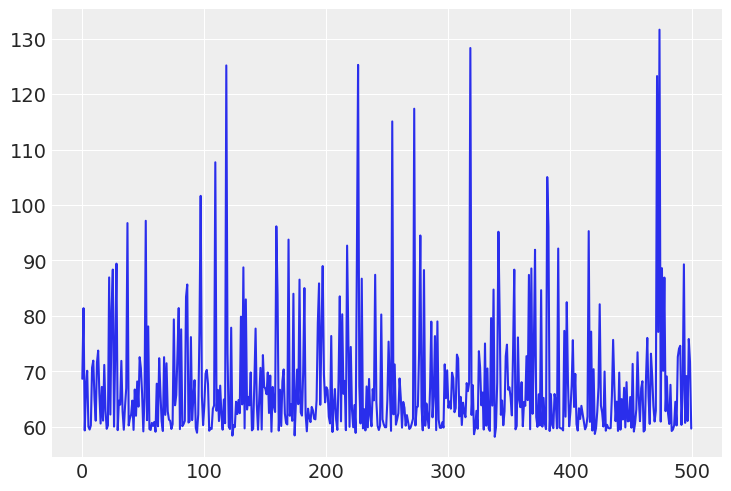

In [168]:
plt.plot(losses)

In [169]:
with pyro.plate("samples", 1000):
    samples = guide(data, a,b,lam_0,mu_0)

Inference data with groups:
	> posterior


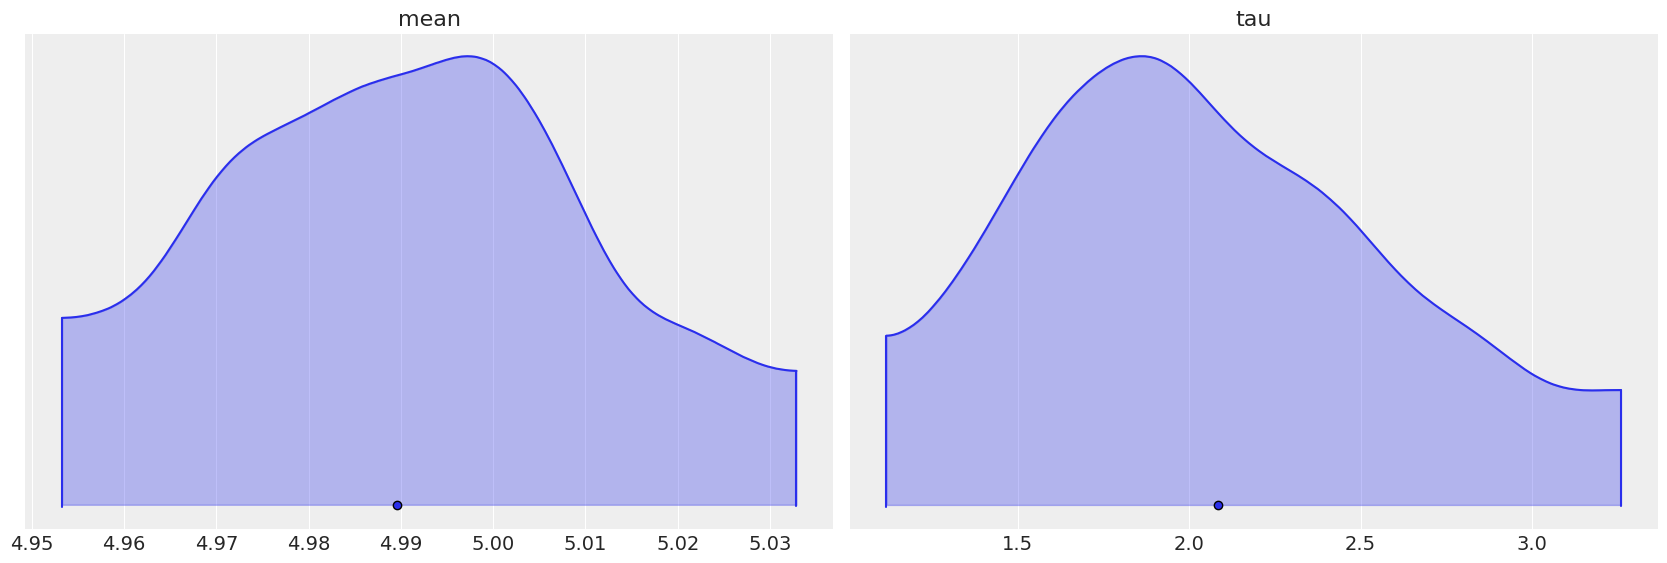

In [170]:
az_data = arviz.from_dict({name:key.detach().numpy() for name, key in samples.items()})
print(az_data)
axes=arviz.plot_density(az_data,shade=0.3)
#axes.flatten()[0].vlines([MEAN],0,10)
#axes.flatten()[1].vlines(1/STD,0,10)

<AxesSubplot:xlabel='mean', ylabel='tau'>

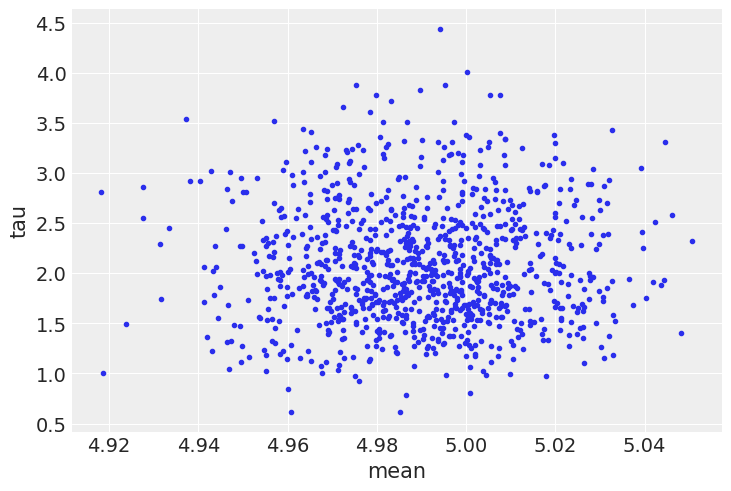

In [171]:
arviz.plot_pair(az_data)

### Plot convergence (loss + mean wrt step)

### Modify the model to use pyro.plate.
Expect horror in tensor shapes. See [this tutorial on tensor shapes in Pyro if you will experience errors](https://pyro.ai/examples/tensor_shapes.html).

a) Try simulating a larger dataset and render the graphical model.
b) See if using plates it changes the params and convergence.
c) What is the relatonship between plates and conditional independence in Pyro? **[TODO]**


In [153]:
def model(data):
    ### WOW, WOW, SUCH CODE ###

SyntaxError: incomplete input (681276684.py, line 2)

In [ ]:
pyro.render_model(model, model_args=(data,), render_distributions=True)

In [ ]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())